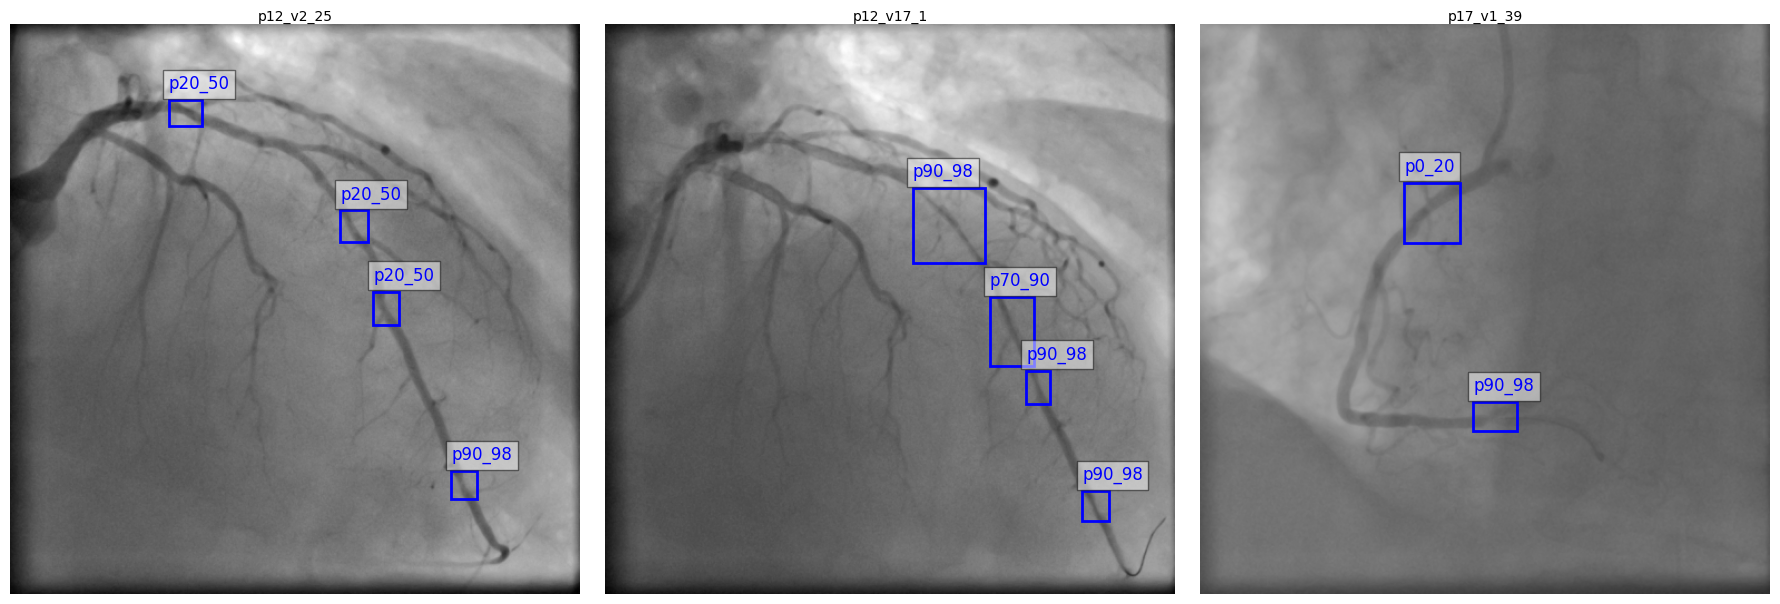

In [36]:
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd

def visualize_bounding_boxes(df, patient_video_frame, ax=None):
    patient, video, frame = patient_video_frame.split("_")
    frame = int(frame)  

    row = df[(df['Patient'] == patient) & (df['Video'] == video) & (df['Frame'] == frame)]
    if row.empty:
        raise ValueError(f"No data found for input: {patient_video_frame}")

    image_path = row.iloc[0]['SelectedFramesLesionVideo']
    bbox_file_path = row.iloc[0]['GroundTruthFile']

    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")
    if not os.path.exists(bbox_file_path):
        raise FileNotFoundError(f"Ground truth file not found: {bbox_file_path}")

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for visualization

    # Read and parse bounding box file
    with open(bbox_file_path, 'r') as file:
        bbox_data = file.readlines()

    bboxes = []
    for line in bbox_data:
        parts = line.strip().split()
        x, y, w, h = map(int, parts[:4])  # First 4 elements are [x, y, w, h]
        tag = parts[4]  # Last element is the lesion tag
        bboxes.append((x, y, w, h, tag))

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)
    ax.axis('off')

    for (x, y, w, h, tag) in bboxes:
        ax.add_patch(plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='blue', facecolor='none'))
        ax.text(x, y -10, tag, color='blue', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    ax.set_title(f"{patient_video_frame}", fontsize=10, pad=-10)
    return ax

data = pd.read_csv(filepath_or_buffer="/home/mariopasc/Python/Datasets/Coronario_Patient/information_dataset.csv")

inputs_1 = ["p11_v14_7", "p23_v1_15", "p23_v10_10"]
inputs = ["p12_v2_25", "p12_v17_1", "p17_v1_39"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, patient_video_frame in enumerate(inputs):
    visualize_bounding_boxes(data, patient_video_frame, ax=axes[i])

plt.tight_layout()
plt.savefig('show_images_2.svg')
plt.show()
